In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
import os
import vis_cpu
from astropy import constants, units
from astropy.time import Time
from astropy.coordinates import Longitude, Latitude, EarthLocation
from scipy.optimize import minimize
from scipy import special
from pyuvdata import UVBeam
from pyradiosky import SkyModel
from pyuvsim import AnalyticBeam
%matplotlib inline

In [2]:
beam_file = "NF_HERA_Dipole_efield_beam.fits"
# hpx_beam_file = "NF_HERA_dipole_linpol_power_healpix128.fits"
# gleam_file = "gleam-120.02-127.34MHz-nf-76-pld.skyh5"
# egsm_file = "egsm_pred_50_200mhz.h5.npz"
# array_file = "array_layout.csv"
# haslam_file = "haslam408_dsds_Remazeilles2014.fits"
# for f in (beam_file, hpx_beam_file, gleam_file, egsm_file, array_file, haslam_file):
#     assert os.path.exists(f)

In [3]:
sep = 14.6
diameter = 10
beam = AnalyticBeam("airy", diameter=diameter)
beam.efield_to_power()
# beam = UVBeam.from_file(beam_file)
# beam.interpolation_function = "az_za_simple"
# beam.freq_interp_kind = "cubic"
# setattr(beam, "type", "NF_Dipole")

array_layout = hera_sim.antpos.hex_array(3, sep=sep, outriggers=0, split_core=False)
add_jitter = False
if add_jitter:
    jitter_amp = 0.05
    radii = np.random.normal(size=len(array_layout), loc=0, scale=jitter_amp*sep)
    angles = np.random.uniform(low=0, high=2*np.pi, size=len(array_layout))
    dx = radii * np.exp(1j*angles)
    for ant, pos in array_layout.items():
        array_layout[ant] = pos + np.array([dx[ant].real, dx[ant].imag, 0])

n_freqs = 1
start_freq = 150e6
channel_width = 100e3
n_times = 1
start_time = 2458099.28
integration_time = 60 * 15
uvdata = hera_sim.io.empty_uvdata(
    array_layout=array_layout,
    Nfreqs=n_freqs,
    start_freq=start_freq,
    channel_width=channel_width,
    Ntimes=n_times,
    start_time=start_time,
    integration_time=integration_time,
#     polarization_array=np.array(['xx','yy']),
)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [4]:
lst = uvdata.lst_array[0]
n_side = 128
n_pix = healpy.nside2npix(n_side)
lat, lon, _ = uvdata.telescope_location_lat_lon_alt
ells = np.arange(3 * n_side)
true_cl = 1 / (1+ells)**2
stokes = np.zeros((4,1,n_pix), dtype=float)
stokes[0,0] = healpy.synfast(true_cl, n_side)
stokes[0,0] += np.abs(stokes[0,0].min())

In [5]:
sky_model = SkyModel(
    stokes=stokes*units.Jy/units.sr,
    spectral_type="flat",
    component_type="healpix",
    nside=n_side,
    hpx_inds=np.arange(n_pix),
)

In [6]:
beam_ids = [0,] * len(array_layout)

In [7]:
data_model = hera_sim.visibilities.ModelData(
    uvdata=uvdata,
    sky_model=sky_model,
    beam_ids=beam_ids,
    beams=[beam,],
)

In [8]:
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)

In [9]:
simulation.simulate();

In [10]:
reds, _, lens, conj = uvdata.get_redundancies(include_conjugates=True)
conj = set(conj)

In [11]:
data = []
ant_1_array = []
ant_2_array = []
edges = [0,]
idx = 0
min_length = np.sqrt(2) * diameter
for group, length in zip(reds, lens):
    if (length <= min_length) or (len(group) < 5):
        continue
    for bl in group:
        ai, aj = uvdata.baseline_to_antnums(bl)
        if bl in conj:
            ai, aj = aj, ai
        data.append(np.atleast_1d(uvdata.get_data(ai,aj,"xx").squeeze()))
        ant_1_array.append(ai)
        ant_2_array.append(aj)
        idx += 1
    edges.append(idx)
data = np.asarray(data).squeeze()
ant_1_array = np.asarray(ant_1_array)
ant_2_array = np.asarray(ant_2_array)
edges = np.asarray(edges)

In [12]:
pos, ants = uvdata.get_ENU_antpos()

In [13]:
snr = 1000
noise_amp = np.abs(data).max() / snr
noise = np.eye(uvdata.Nbls, dtype=complex) * noise_amp**2
noise_diag = np.diag(noise)

n_ants = ants.size
err = 0.05
phs_err = 5 * units.deg.to("rad")
amps = np.random.normal(loc=1, size=n_ants, scale=err)
phases = np.random.uniform(0, 2*np.pi, n_ants)
phase_err = np.random.normal(loc=0, size=n_ants, scale=phs_err)
gain = amps * np.exp(1j*(phases+phase_err))
true_gains = np.exp(1j*phases)
re_gain = gain.real
im_gain = gain.imag
# re_gain = np.random.normal(loc=1, size=n_ants, scale=err)
# im_gain = np.random.normal(loc=0, size=n_ants, scale=err)
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = re_gain
split_gains[1::2] = im_gain

In [14]:
data *= true_gains[ant_1_array] * true_gains[ant_2_array].conj()

In [15]:
lat, lon, _ = uvdata.telescope_location_lat_lon_alt
enu_antpos = uvdata.get_ENU_antpos()[0]
za, az = healpy.pix2ang(n_side, np.arange(healpy.nside2npix(n_side)))
sky_power = healpy.anafast(stokes[0,0], use_pixel_weights=True)

# Make the power beam
power_beam = AnalyticBeam("airy", diameter=diameter)
power_beam.efield_to_power()

# UVBeam convention is different from HEALPix convention
beam_vals = power_beam.interp(
    az_array=Longitude((az - np.pi/2)*units.rad).value,
    za_array=za,
    freq_array=uvdata.freq_array.squeeze(),
)[0][0,0,0,0]

# Enforce a horizon cut
beam_vals[za>np.pi/2] = 0
sky_crd = np.array(
    [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
)

In [16]:
lst = uvdata.lst_array[0]
rotation = vis_cpu.conversions.enu_to_eci_matrix(lst, lat)
enu_antpos = uvdata.get_ENU_antpos()[0]
ecef_antpos = (rotation @ enu_antpos.T).T
uvws = uvdata.freq_array[0,0] * (
    ecef_antpos[ant_2_array] - ecef_antpos[ant_1_array]
) / constants.c.value
fringe = np.exp(-2j * np.pi * uvws @ sky_crd)

# Rotate the beam
beam_alms = healpy.map2alm(beam_vals, use_pixel_weights=True)
healpy.rotate_alm(beam_alms, 0, np.pi/2-lat, lst)
rotated_beam = healpy.alm2map(beam_alms, n_side)

# Build the diffuse matrix
diff_mat =  np.zeros((edges[-1], edges.size - 1), dtype=complex)
ells = np.arange(sky_power.size)
scaling = 2 * ells + 1
for grp in range(diff_mat.shape[1]):
    start, stop = edges[grp:grp+2]
    fringed_beam = rotated_beam * fringe[start]
    beam_spectrum = healpy.anafast(fringed_beam, use_pixel_weights=True)
    cov_amp = np.sum(sky_power * scaling * beam_spectrum)
    diff_mat[start:stop,grp] = np.sqrt(cov_amp)

Casting complex values to real discards the imaginary part


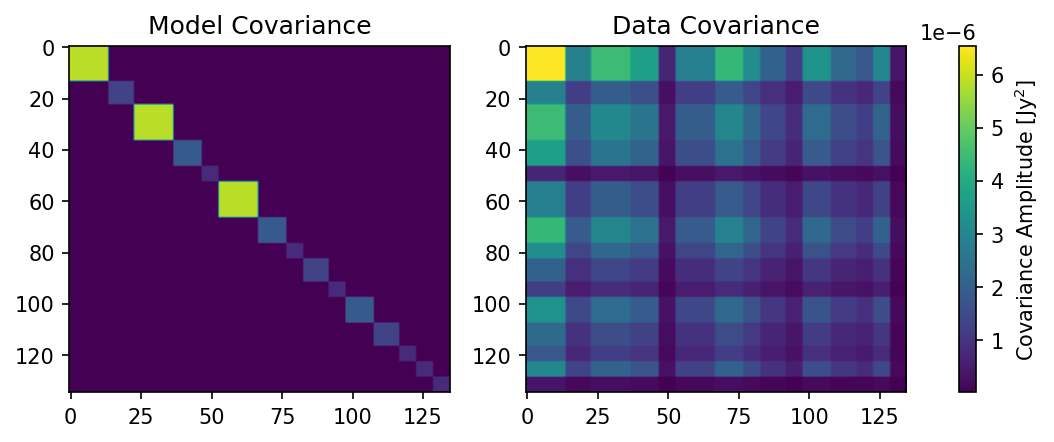

In [17]:
# Now let's compare
data_cov = np.outer(data, data.conj())
model_cov = diff_mat @ diff_mat.T.conj()
fig, axes = plt.subplots(1, 2, figsize=(9,3), dpi=150)
axes[0].set_title("Model Covariance")
axes[1].set_title(f"Data Covariance")
vmin = np.abs(data_cov).min()
vmax = np.abs(data_cov).max()
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
axes[0].imshow(np.abs(model_cov), aspect='auto', norm=norm, cmap=cmap)
axes[1].imshow(np.abs(data_cov), aspect='auto', norm=norm, cmap=cmap)
cbar = fig.colorbar(smap, ax=axes)
cbar.set_label(r"Covariance Amplitude [Jy$^2$]")

In [18]:
class Cov:
    def __init__(self, noise, diff_mat, src_mat, gains, edges, ant_1_inds, ant_2_inds):
        self.noise = noise
        self.diff_mat = diff_mat
        self.src_mat = src_mat
        self.gains = gains
        self.edges = edges
        self.ant_1_inds = ant_1_inds
        self.ant_2_inds = ant_2_inds
        self.n_bls = diff_mat.shape[0]
        self.n_grp = len(edges) - 1
        self.n_eig = diff_mat.shape[1] // self.n_grp
        self.n_src = src_mat.shape[1]
    
    def inv(self, dense=False, return_det=False):
        return self._dense_inv(return_det) if dense else self._sparse_inv(return_det)
    
    def _dense_inv(self, return_det=False):
        gain_mat = self.build_gain_mat()
        sky_cov = self.src_mat@self.src_mat.T.conj() + self.diff_mat@self.diff_mat.T.conj()
        full_cov = self.noise + gain_mat[:,None]*sky_cov*gain_mat[None,:].conj()
        inv = np.linalg.inv(full_cov)
        if return_det:
            try:
                logdet = 2*np.sum(np.log(np.diag(np.linalg.cholesky(full_cov))))
            except np.linalg.LinAlgError:
                logdet = np.inf
            return inv, np.real(logdet)
        return inv
    
    def _sparse_inv(self, return_det=False):
        if return_det:
            logdet = 0
            
        gain_mat = self.build_gain_mat()
        Cinv = np.zeros((self.n_bls, self.n_bls), dtype=complex)
        GD = gain_mat[:,None] * self.diff_mat
        for grp, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
            left = grp * self.n_eig
            right = left + self.n_eig
            
            block = GD[start:stop, left:right].copy()
            block = self.noise[start:stop,start:stop] + block@block.T.conj()
            if return_det:
                logdet += 2*np.sum(np.log(np.diag(np.linalg.cholesky(block))))
            Cinv[start:stop,start:stop] = np.linalg.inv(block)
            
        GS = gain_mat[:,None] * self.src_mat
        CGS = Cinv @ GS
        tmp = np.eye(self.n_src) + GS.T.conj()@CGS
        Cinv -= CGS @ np.linalg.inv(tmp) @ CGS.T.conj()
        
        if return_det:
            logdet += 2 * np.sum(np.log(np.diag(np.linalg.cholesky(tmp))))
            return Cinv, np.real(logdet)
        return Cinv
       
    def build_gain_mat(self):
        gains = self.gains[::2] + 1j*self.gains[1::2]
        return gains[self.ant_1_inds] * gains[self.ant_2_inds].conj()

In [19]:
def nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Negative log-likelihood."""
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=False, return_det=True)
    chisq = data.conj() @ cinv @ data
    # Use a Gaussian prior that the phase should be nearly zero for all antennas
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
#     phs_norm = cov.gains[1::2].sum()**2 / phs_norm_fac**2
    return np.real(chisq) + logdet + phs_norm

In [20]:
def grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Gradient of negative log-likelihood."""
    cov.gains = gains / scale
    complex_gains = (gains[::2] + 1j*gains[1::2]) / scale
    gain_mat = cov.build_gain_mat()
    cinv = cov.inv(dense=False, return_det=False)
    cinv_data = cinv @ data
    grad_nll = np.zeros_like(gains)
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    for k in range(gains.size):
        grad_chisq = 0
        grad_gains = np.zeros_like(gain_mat)
        if k%2 == 0:  # derivative wrt real gain
            grad_gains += np.where(cov.ant_1_inds == k//2, complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
#             grad_phs_norm = 0
        else:
            grad_gains += np.where(cov.ant_1_inds == k//2, 1j*complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, -1j*complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
#             grad_phs_norm = 2 * cov.gains[1::2].sum() / phs_norm_fac**2
        tmp1 = grad_gains[:,None] * cov.src_mat
        tmp2 = cov.src_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov = tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        tmp1 = grad_gains[:,None] * cov.diff_mat
        tmp2 = cov.diff_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov += tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        grad_cov = grad_cov + grad_cov.T.conj()
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = np.real(grad_logdet - 2*grad_chisq + grad_phs_norm)  # actually calculated -grad_chisq/2, so this is right
    return grad_nll / scale

In [21]:
cov = Cov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=np.zeros((ant_1_array.size,1), dtype=complex),
    gains=split_gains,
    edges=edges,
    ant_1_inds=ant_1_array,
    ant_2_inds=ant_2_array,
)

In [22]:
scale = 1
phs_norm_fac = 1e-1

In [23]:
result = minimize(
    nll,
    scale*split_gains,
    args=(cov, data, scale, phs_norm_fac),
    method="CG",
    jac=grad_nll,
)

In [24]:
result.nit, result.nfev, result.njev

(41, 113, 106)

In [25]:
def rephase_to_ant(gain, refant):
    rephased_gain = np.zeros_like(gain)
    g0 = np.array([gain[refant]])[0]
    for ant, g in enumerate(gain):
        rephased_gain[ant] = g * g0.conj() / np.abs(g0)
    return rephased_gain

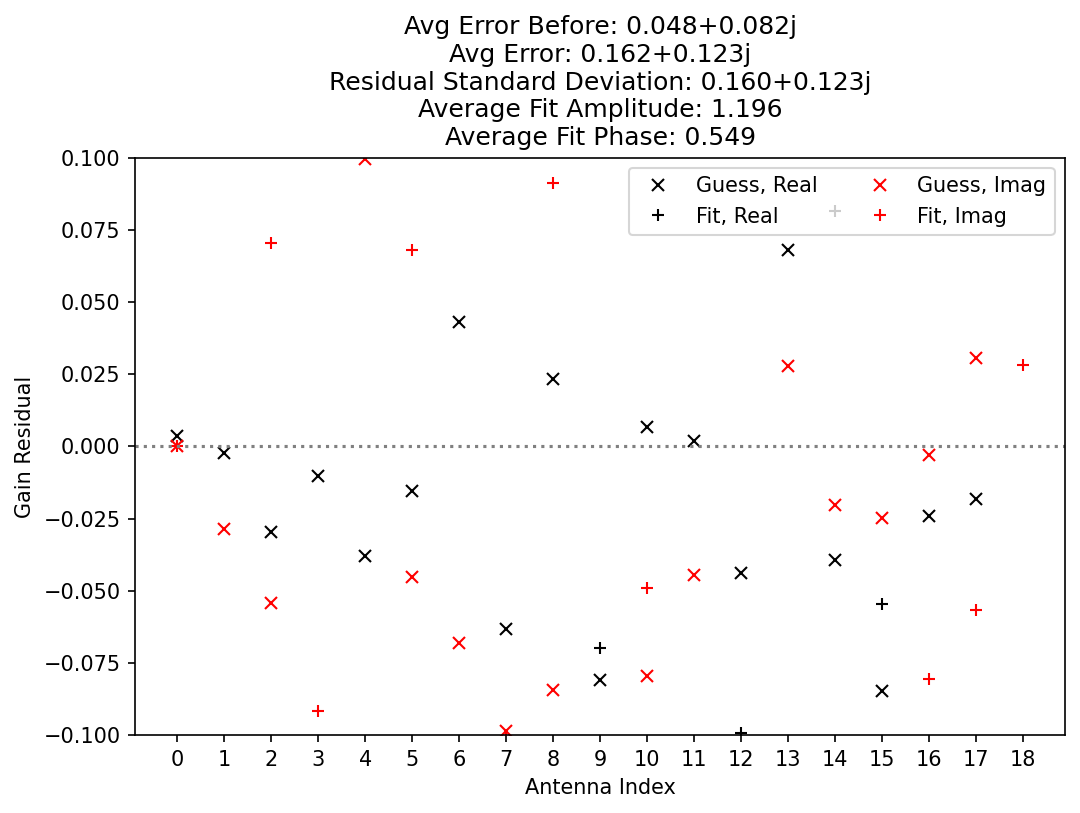

In [26]:
fit = (result.x[::2] + 1j*result.x[1::2]) / scale
fit = rephase_to_ant(fit, 0)
gain = rephase_to_ant(gain, 0)
true_gains = rephase_to_ant(true_gains, 0)
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gain.real, true_gains.real) + 1j*err(gain.imag, true_gains.imag)
avg_err = err(fit.real, true_gains.real) + 1j*err(fit.imag, true_gains.imag)
fit_std = np.std(fit.real-true_gains.real) + 1j*np.std(fit.imag-true_gains.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error: {avg_err:.3f}\n"
title += f"Residual Standard Deviation: {fit_std:.3f}\n"
title += f"Average Fit Amplitude: {np.mean(np.abs(fit)):.3f}\n"
title += f"Average Fit Phase: {np.mean(np.angle(fit)):.3f}"
plt.title(title)
plt.plot(gain.real - true_gains.real, 'kx', label='Guess, Real')
plt.plot(fit.real - true_gains.real, 'k+', label='Fit, Real')
plt.plot(gain.imag - true_gains.imag, 'rx', label='Guess, Imag')
plt.plot(fit.imag - true_gains.imag, 'r+', label='Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
plt.xticks(np.arange(n_ants));
basename = f"gain_solutions_diffuse_sky_nontrivial_cl_{beam.type}_beam"
# plt.savefig(f"{basename}_without_noise.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{basename}_with_noise.png", dpi=150, bbox_inches="tight")

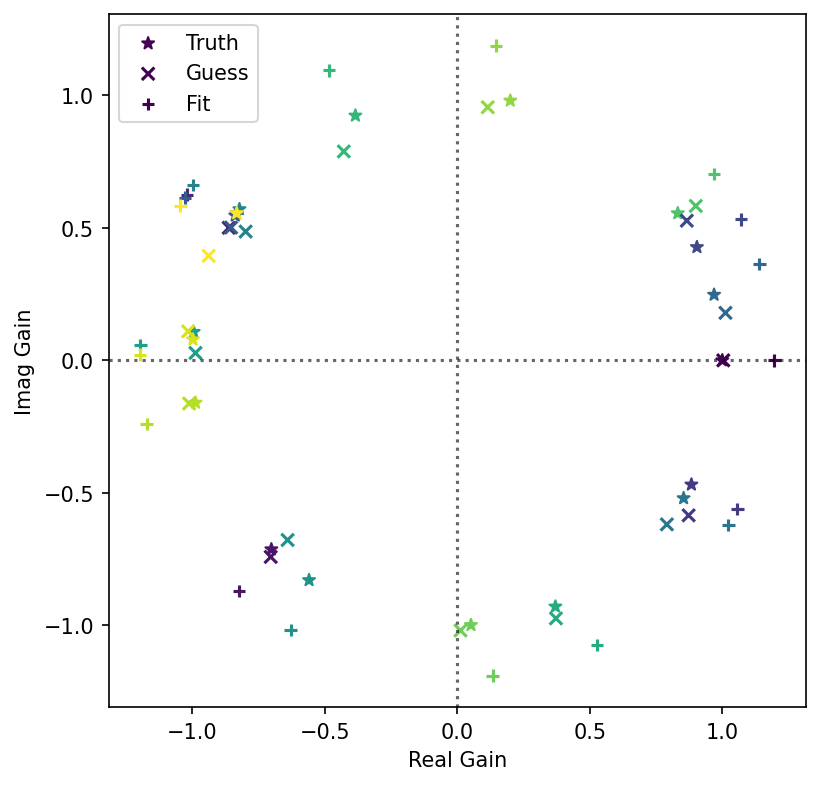

In [27]:
plt.figure(figsize=(6,6), dpi=150)
plt.axhline(0, ls=':', color='k', alpha=0.6)
plt.axvline(0, ls=':', color='k', alpha=0.6)
plt.scatter(true_gains.real, true_gains.imag, c=np.arange(n_ants), marker='*', label="Truth")
plt.scatter(gain.real, gain.imag, c=np.arange(n_ants), marker='x', label="Guess")
plt.scatter(fit.real, fit.imag, c=np.arange(n_ants), marker='+', label="Fit")
plt.gca().set_aspect('equal')
plt.xlabel("Real Gain")
plt.ylabel("Imag Gain")
plt.legend(loc="upper left")

In [ ]:
# TODO: check how the likelihood compares at the optimal solution vs the true solution
# also check how the extra noise variance compares to the actual variance in the data